**BEFORE YOU FORK, PLEASE SUPPORT AND UPVOTE**

Versions:
* v3: first scoring kernel (LB 0.676)
* v5: Longer epochs, export model, and optimize kappa (LB 0.705)
* v8: Converted to regression problem, as required by the QWK optimizer(LB 0.722)
* v11: Added TTA and seed

# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

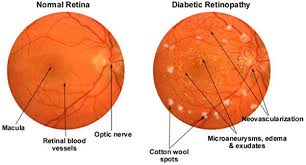

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes a previous [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite important. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

...

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [4]:
import os
os.listdir('../input')

['aptos2019-blindness-detection', 'resnet50']

In [5]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

## Reading data and Basic EDA

Here I am going to open the dataset with pandas, check distribution of labels.

In [7]:
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,diagnosis,path
0,2,../input/aptos2019-blindness-detection/train_i...
1,1,../input/aptos2019-blindness-detection/train_i...
2,0,../input/aptos2019-blindness-detection/train_i...
3,4,../input/aptos2019-blindness-detection/train_i...
4,0,../input/aptos2019-blindness-detection/train_i...
5,3,../input/aptos2019-blindness-detection/train_i...
6,2,../input/aptos2019-blindness-detection/train_i...
7,0,../input/aptos2019-blindness-detection/train_i...
8,0,../input/aptos2019-blindness-detection/train_i...
9,1,../input/aptos2019-blindness-detection/train_i...


In [8]:
len_df = len(df)
print(f"There are {len_df} images")

There are 3662 images


This is actually very small. The [previous competition](https://kaggle.com/c/diabetic-retinopathy-detection) had ~35k images, which supports the idea that pretraining on that dataset may be quite beneficial.

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.

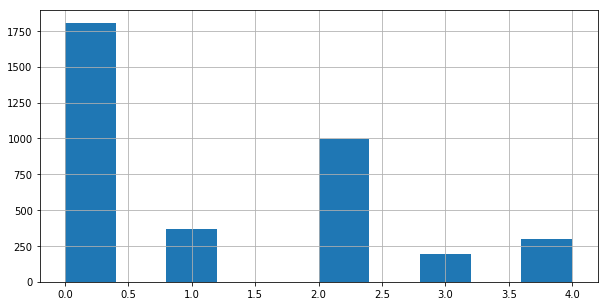

In [9]:
df['diagnosis'].hist(figsize = (10, 5))

Let's look at an example image:

In [10]:
from PIL import Image

im = Image.open(df['path'][1])
width, height = im.size
print(width,height) 
im.show()

2896 1944


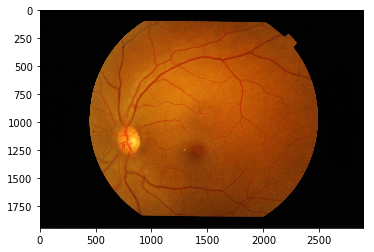

In [11]:
plt.imshow(np.asarray(im))

The images are actually quite big. We will resize to a much smaller size.

In [12]:
bs = 64 #smaller batch size is better for training, but may take longer
sz=224

In [13]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

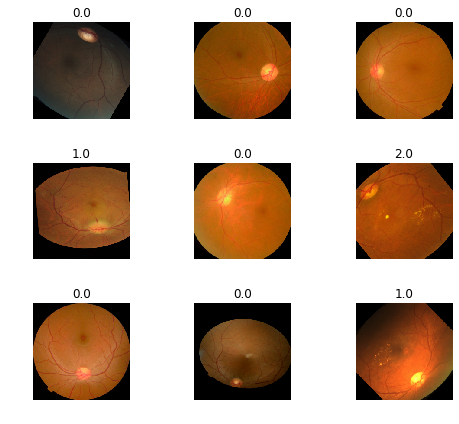

In [14]:
data.show_batch(rows=3, figsize=(7,6))

## Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [15]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [16]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics = [quadratic_kappa])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.74E-02


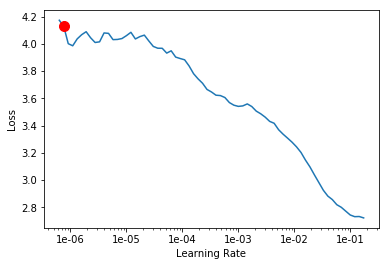

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Here we can see that the loss decreases fastest around `lr=1e-2` so that is what we will use to train:

In [18]:
learn.fit_one_cycle(4,max_lr = 1e-2)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,1.914036,0.737217,0.779682,09:04
1,0.980406,0.504287,0.772098,08:52
2,0.650737,0.344382,0.869197,08:57
3,0.487535,0.332291,0.862428,08:55


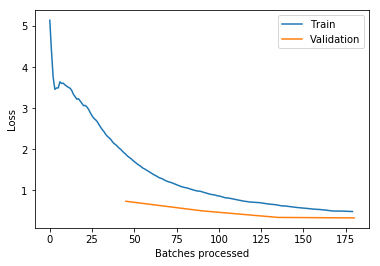

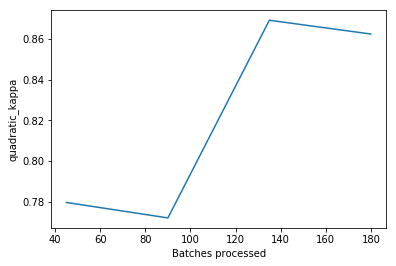

In [19]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


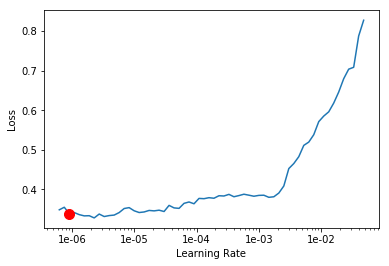

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.346465,0.328048,0.863198,08:57
1,0.357889,0.307021,0.877721,08:59
2,0.348243,0.294872,0.877341,08:57
3,0.320800,0.276511,0.889944,08:57
4,0.306295,0.266796,0.899261,08:59
5,0.286028,0.269153,0.896457,09:00


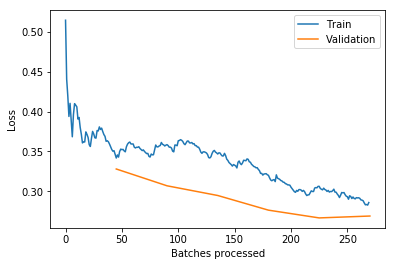

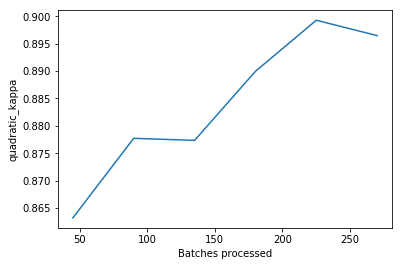

In [22]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [23]:
learn.export()
learn.save('stage-2')

Let's evaluate our model:

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [25]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Optimize the Metric

Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [26]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)

In [27]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [28]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [29]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

0.9035357302700283


In [30]:
coefficients = optR.coefficients()
print(coefficients)

[0.504171 1.597531 2.416886 3.305622]


## TTA

Test-time augmentation, or TTA, is a commonly-used technique to provide a boost in your score, and is very simple to implement. Fastai already has TTA implemented, but it is not the best for all purposes, so I am redefining the fastai function and using my custom version.

In [31]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=10) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=10, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

## Submission
Let's now create a submission

In [32]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [33]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [34]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [35]:
test_predictions = optR.predict(preds, coefficients)

In [36]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [37]:
sample_df.to_csv('submission.csv',index=False)